In [19]:
!pip install scanpy squidpy

In [20]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
print("Work bench ready!")


Work bench ready!


In [21]:
adata = sq.datasets.visium_fluo_adata_crop()
img = sq.datasets.visium_fluo_image_crop()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print("Data loaded and cleaned")

Data loaded and cleaned


In [22]:
sq.im.calculate_image_features(
    adata,
    img,
    features="summary",
    key_added="image_features",
    n_jobs=1
)

X = pd.DataFrame(adata.obsm["image_features"])

print(X.head())

  0%|          | 0/704 [00:00<?, ?/s]

                    summary_ch-0_quantile-0.9  ...  summary_ch-2_std
AAACGAGACGGTTGAT-1                    29248.0  ...        674.716569
AAAGGGATGTAGCAAG-1                     9072.0  ...       1370.347940
AAATGGCATGTCTTGT-1                    21584.0  ...       1218.039239
AAATGGTCAATGTGCC-1                    24100.0  ...       1357.385838
AAATTAACGGGTAGCT-1                    10908.0  ...       1435.166787

[5 rows x 15 columns]


In [23]:
target_gene = 'Rpl37a'

y = adata[:, target_gene].X.toarray().flatten()

print(f"Ready to predict {target_gene}. First 5 values: {y[:5]}")

Ready to predict Rpl37a. First 5 values: [1.9869795 1.716779  1.8437595 1.6087528 1.8489037]


In [24]:
model = Ridge(alpha=1.0)

model.fit(X, y)

y_pred = model.predict(X)

adata.obs["predicted_gene"] = y_pred

print(adata.obs["predicted_gene"].head())

print("AI Training Complete.")

AAACGAGACGGTTGAT-1    1.808502
AAAGGGATGTAGCAAG-1    1.841253
AAATGGCATGTCTTGT-1    1.775717
AAATGGTCAATGTGCC-1    1.949241
AAATTAACGGGTAGCT-1    1.821714
Name: predicted_gene, dtype: float64
AI Training Complete.


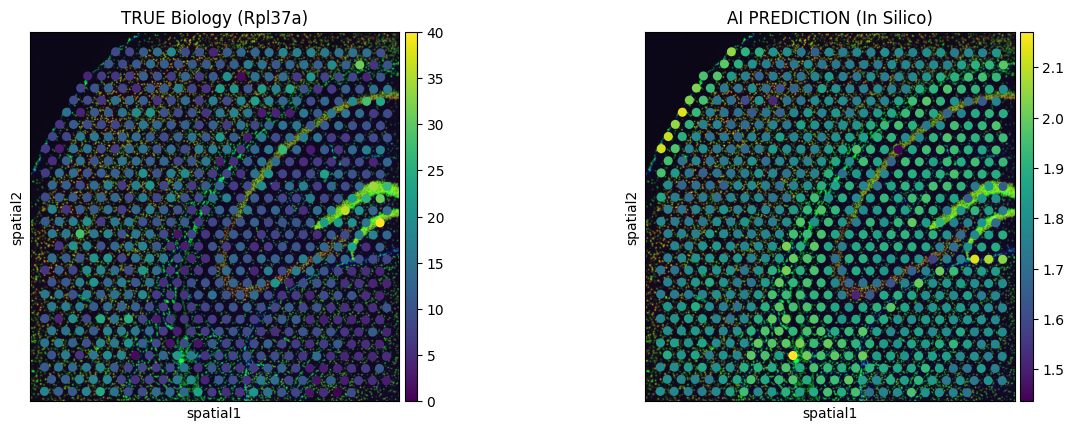

In [25]:
sq.pl.spatial_scatter(
    adata,
    color=[target_gene, "predicted_gene"], # Compare Real vs Predicted
    title=["TRUE Biology (Rpl37a)", "AI PREDICTION (In Silico)"],
    cmap="viridis" # Color map (Purple to Yellow)
)

In [26]:
score = np.corrcoef(y, y_pred)[0, 1]
print(f"Model Accuracy (Pearson R): {score:.4f}")

Model Accuracy (Pearson R): 0.4774


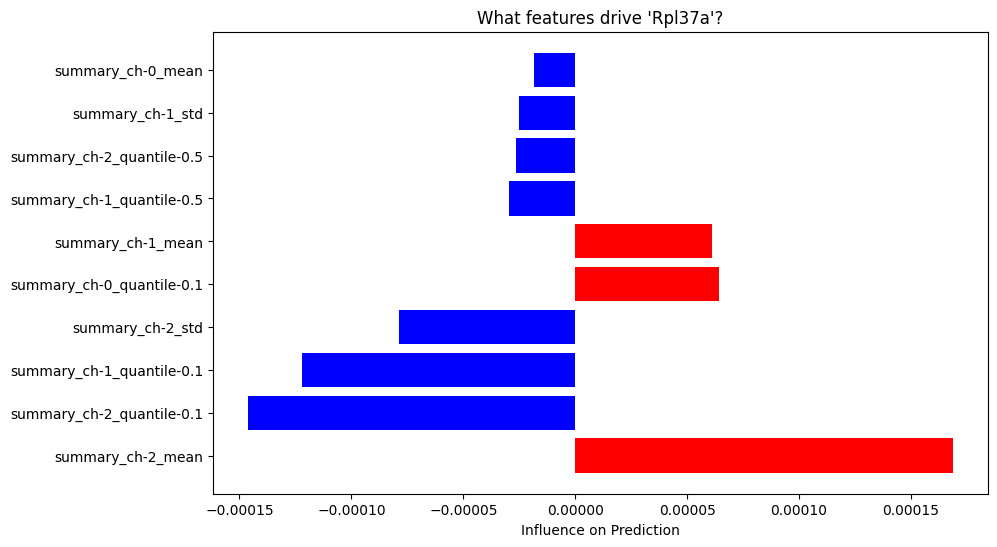

In [27]:
import matplotlib.pyplot as plt

# 1. Extract the weights (coefficients) from the trained model
weights = model.coef_

# 2. Get the feature names (the column headers from X)
feature_names = X.columns

# 3. Organize them into a nice table
importance = pd.DataFrame({
    "Feature": feature_names,
    "Weight": weights
})

# 4. Sort by absolute impact (ignoring positive/negative sign for sorting)
importance["Abs_Weight"] = importance["Weight"].abs()
top_features = importance.sort_values("Abs_Weight", ascending=False).head(10)

# 5. Visualize the Drivers
plt.figure(figsize=(10, 6))
# Color code: Red = Positive Correlation, Blue = Negative Correlation
colors = ["red" if x > 0 else "blue" for x in top_features["Weight"]]

plt.barh(top_features["Feature"], top_features["Weight"], color=colors)
plt.title(f"What features drive '{target_gene}'?")
plt.xlabel("Influence on Prediction")
plt.show()